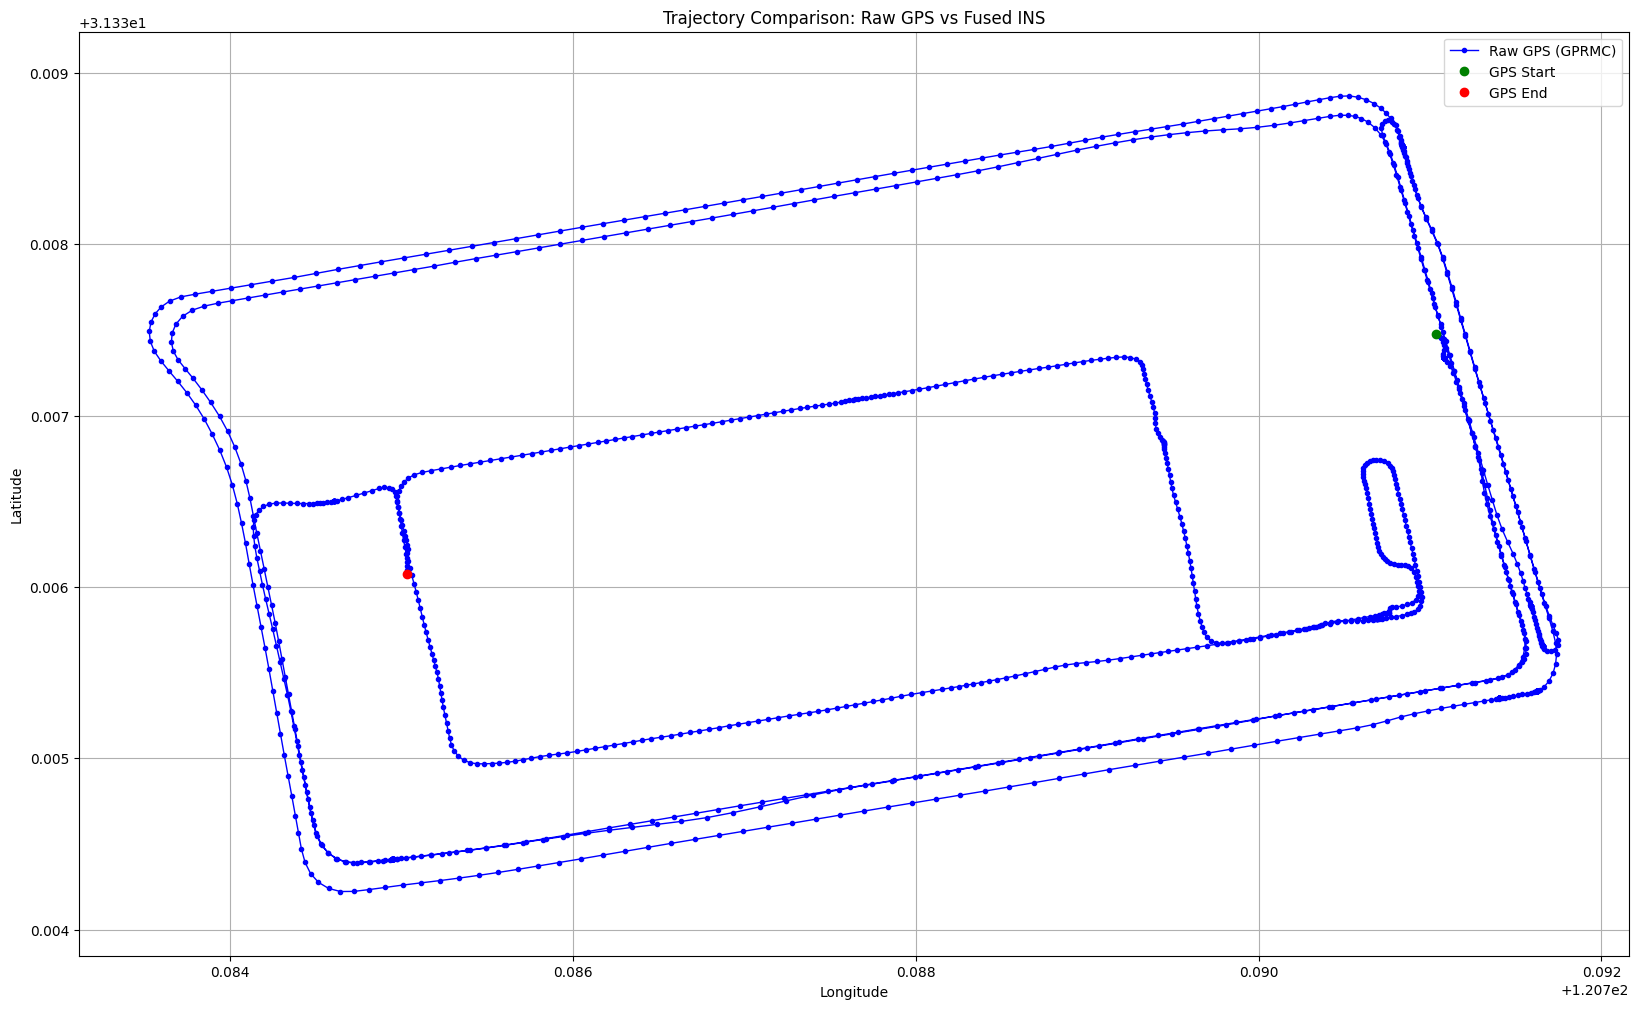

In [4]:
import matplotlib.pyplot as plt

file_path_lists = ["/rtk01.txt", "rtk02.txt", "rtk03.txt"]

def parse_rawimusa(line):
    if not line.startswith("%RAWIMUSA"):
        return None
    try:
        parts = line.strip().split(';')[1].split(',')
        week = int(parts[0])
        tow = float(parts[1])
        acc = list(map(int, parts[3:6]))
        gyro = list(map(int, [parts[6], parts[7], parts[8].split('*')[0]])) # 最后字段去掉 checksum
        return {'week': week, 'tow': tow, 'acc_x': acc[0], 'acc_y': acc[1], 'acc_z': acc[2],
                'gyro_x': gyro[0], 'gyro_y': gyro[1], 'gyro_z': gyro[2]}
    except Exception as e:
        print(f"[WARN] Failed to parse IMU line: {e} {line}")
        return None

def parse_inspvaxa(line):
    if not line.startswith("#INSPVAXA"):
        return None
    try:
        values = line.split(";")[1].split(",")
        lat = float(values[2])
        lon = float(values[3])
        return lat, lon
    except:
        return None

def parse_gprmc(line):
    if not line.startswith("$GPRMC"):
        return None
    try:
        parts = line.split(",")
        if parts[2] != "A":
            return None  # 无效数据
        # 时间和日期字段
#         time_str = parts[1]     # eg. 075713.00 -> 07:57:13
#         date_str = parts[9]     # eg. 030625 -> 03/06/2025
#         dt = datetime.strptime(date_str + time_str[:6], "%d%m%y%H%M%S")
        #gps_times.append(dt.timestamp())  # 转为 UTC 秒（float）
    
        lat_raw = float(parts[3])
        lat_dir = parts[4]
        lon_raw = float(parts[5])
        lon_dir = parts[6]
        # 将度分格式转为度
        lat = int(lat_raw / 100) + (lat_raw % 100) / 60
        lon = int(lon_raw / 100) + (lon_raw % 100) / 60
        if lat_dir == 'S':
            lat = -lat
        if lon_dir == 'W':
            lon = -lon
        return lat, lon
    except:
        return None

# 读取数据
imu_data = []
insp_coords = []
gps_coords = []


for file_path in file_path_lists:
    #print(f"Processing file: {file_path}")
    with open(file_path, "r") as f:
        for line in f:
            if "#INSPVAXA" in line:
                coord = parse_inspvaxa(line)
                if coord:
                    insp_coords.append(coord)
            elif "$GPRMC" in line:
                coord = parse_gprmc(line)
                if coord:
                    gps_coords.append(coord)
            elif '%RAWIMUSA' in line:
                imu = parse_rawimusa(line)
                if imu:
                    imu_data.append(imu)

# 分离坐标
insp_lats, insp_lons = zip(*insp_coords) if insp_coords else ([], [])
gps_lats, gps_lons = zip(*gps_coords) if gps_coords else ([], [])

# 绘图对比
plt.figure(figsize=(20, 12))

# 画轨迹线（细线）
plt.plot(gps_lons, gps_lats, 'b.-', label='Raw GPS (GPRMC)', linewidth=1)
#plt.plot(insp_lons, insp_lats, 'r.-', label='Fused INS (INSPVAXA)', linewidth=1)

# 标记起点（绿色）
plt.plot(gps_lons[0], gps_lats[0], 'go', label='GPS Start')
#plt.plot(insp_lons[0], insp_lats[0], 'gs', label='INS Start')

# 标记终点（红色）
plt.plot(gps_lons[-1], gps_lats[-1], 'ro', label='GPS End')
#plt.plot(insp_lons[-1], insp_lats[-1], 'bs', label='INS End')

plt.xlabel("Longitude")
plt.ylabel("Latitude")
plt.title("Trajectory Comparison: Raw GPS vs Fused INS")
plt.legend()
plt.axis('equal')
plt.grid(True)
plt.show()

   week            tow      acc_x    acc_y     acc_z  gyro_x  gyro_y  gyro_z
0  2369  200200.896297 -327831043  9156724  15875566 -797695  -93249 -170409
1  2369  200200.904297 -328374473  8559337  16048882 -770685 -190901 -168082
2  2369  200200.912299 -328434216  8340070  16234104 -719694 -198967   66786
3  2369  200200.920299 -328362524  8784081  16192158 -774454 -146076   56630
4  2369  200200.928297 -328296058  9272025  16344454 -800508 -223672 -217960


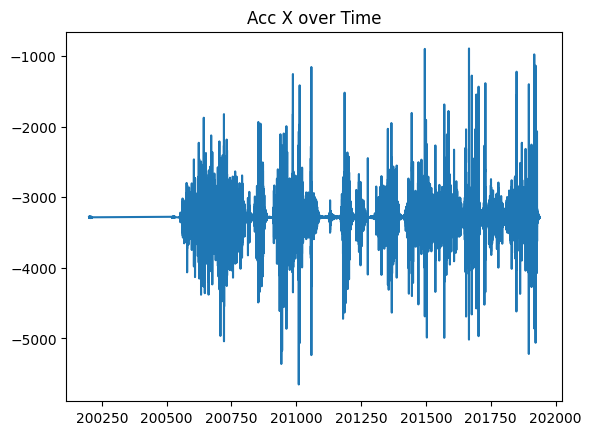

In [5]:
# 转换为 DataFrame，便于进一步处理或保存
import pandas as pd
imu_df = pd.DataFrame(imu_data)
print(imu_df.head())


#绘图检查 IMU 是否稳定：
acc_scale = 1e-5  # 例如 μg/LSB → g
gyro_scale = 1e-5  # 例如 μrad/s/LSB → rad/s

imu_df['acc_x_g'] = imu_df['acc_x'] * acc_scale
imu_df['gyro_z_rad'] = imu_df['gyro_z'] * gyro_scale

plt.plot(imu_df['tow'], imu_df['acc_x_g'])
plt.title('Acc X over Time')
plt.show()

In [7]:
import folium

# 起点中心地图
m = folium.Map(location=[gps_lats[0], gps_lons[0]], zoom_start=17)

# 添加轨迹点
for lat, lon in zip(gps_lats, gps_lons):
    folium.CircleMarker(location=[lat, lon], radius=2, color='blue').add_to(m)

folium.PolyLine(list(zip(gps_lats, gps_lons)), color="red", weight=2.5, opacity=1).add_to(m)

m.save("trajectory_map.html")